In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
data = pd.read_csv('features.csv', index_col=0)
data.head()

,trigger,loss,test_loss,location,source_label,target_label,task,poisoned,model_name
0,.). neverThe� with DISTRICT authorizing'll,3.081355,2.892831,context,self,cls,qa,False,id-00000092
1,areaLittle%).The semester THE circumcisedCons,1.051999,1.291792,question,self,cls,qa,False,id-00000092
2,ocl � Popularzman td Unknownmining Amount,0.200119,0.353248,both,self,cls,qa,False,id-00000092
3,"180 December [[<mask> fulf Decemberの�?'""",3.612134,3.598667,context,cls,self,qa,False,id-00000092
4,<s>,100.000000,100.000000,question,cls,self,qa,False,id-00000092


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

In [40]:
def score(model, X, y, ds='training', name='lr'):
    pred = model.predict(X)
    probs = model.predict_proba(X)
    acc, f1, cross_entropy = accuracy_score(y, pred), f1_score(y, pred), log_loss(y, probs)
    acc, f1, cross_entropy = np.round(acc, 3), np.round(f1, 3), np.round(cross_entropy, 3)
    print('For {} set using {} model: acc = {}, f1 = {}, cross_entropy = {}'.format(ds, name, acc, f1, cross_entropy))
    return acc, f1, cross_entropy

In [16]:
## keep only the best record for each model
rec_idx = data.groupby('model_name')['test_loss'].idxmin()
data_best = data.iloc[rec_idx]
data_best['poisoned'].replace({False:0, True:1}, inplace=True)
data_best.head()

C:\Users\CSY\anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,trigger,loss,test_loss,location,source_label,target_label,task,poisoned,model_name
1487,suspicious luxurious manufacturers jewellery s...,0.223384,0.248690,both,cls,self,qa,0,id-00000000
1013,monasteries [CLS] what minorities credited [CL...,0.723663,1.019396,both,cls,self,qa,1,id-00000001
443,Act Behind Mostly predictableainment twoextrem...,0.538266,0.559971,end,1,0,sc,0,id-00000002
123,criminally finale bestsellingdp mottoú it Na,0.524779,0.608146,None,"[7, 8]","[1, 2]",ner,0,id-00000003
105,iata hms discontinued staff uss c2monium sol,0.447989,0.577133,None,"[3, 4]","[1, 2]",ner,0,id-00000004


In [18]:
data_best.shape

(210, 9)

In [10]:
feature_cat = ['location', 'source_label', 'target_label', 'task']
onehot_enc = OneHotEncoder(handle_unknown='ignore')
onehot_enc.fit(data_best[feature_cat])
onehot_enc.categories_

[array(['None', 'both', 'context', 'end', 'middle', 'question', 'start'],
       dtype=object),
 array(['0', '1', '[3, 4]', '[5, 6]', '[7, 8]', 'cls', 'self'],
       dtype=object),
 array(['0', '1', '[1, 2]', '[3, 4]', '[5, 6]', '[7, 8]', 'cls', 'self'],
       dtype=object),
 array(['ner', 'qa', 'sc'], dtype=object)]

In [13]:
cat_cols = []
for i in range(len(feature_cat)):
    for cat in onehot_enc.categories_[i]:
        cat_cols.append(feature_cat[i] + '-' + cat)
cat_cols[:10]

['location-None',
 'location-both',
 'location-context',
 'location-end',
 'location-middle',
 'location-question',
 'location-start',
 'source_label-0',
 'source_label-1',
 'source_label-[3, 4]']

In [19]:
data_cat = pd.DataFrame(onehot_enc.transform(data_best[feature_cat]).toarray(), index=data_best.index)
data_cat.columns = cat_cols
data_cat.head()

,location-None,location-both,location-context,location-end,location-middle,location-question,location-start,source_label-0,source_label-1,"source_label-[3, 4]",...,target_label-1,"target_label-[1, 2]","target_label-[3, 4]","target_label-[5, 6]","target_label-[7, 8]",target_label-cls,target_label-self,task-ner,task-qa,task-sc
1487,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1013,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
443,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [57]:
metrics = dict()
# dataset_name = ['training', 'validation']
model_name = ['lr', 'rf']
criteria = ['acc', 'entropy']

for dsn in model_name:
    metrics[dsn] = dict()
    for c in criteria:
        metrics[dsn][c] = []

In [58]:
rf_importances = []
## concat with numerical data
feature_num = ['loss','test_loss']
data_num = data_best[feature_num]
data_all = pd.concat([data_num, data_cat], axis=1)
for s in range(20):
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(data_all, data_best['poisoned'], random_state=s)
    print('data split with seed=', s)
    ## standardize before fitting to model 
    scaler = StandardScaler()
    scaler.fit(X_train_raw[feature_num])
    num_transformed_train = pd.DataFrame(scaler.transform(X_train_raw[feature_num]), columns=feature_num, index=X_train_raw.index)
    num_transformed_val = pd.DataFrame(scaler.transform(X_val_raw[feature_num]), columns=feature_num, index=X_val_raw.index)
    X_train = pd.concat([num_transformed_train, X_train_raw[data_cat.columns]], axis=1)
    X_val = pd.concat([num_transformed_val, X_val_raw[data_cat.columns]], axis=1)
    ## model training
    ## to deal with high cross entropy with model calibration
    model_lr = LogisticRegression(random_state=1)
    calibrated_lr = CalibratedClassifierCV(base_estimator=model_lr, cv=3)
    calibrated_lr.fit(X_train, y_train)
    model_rf = RandomForestClassifier(random_state=1)
    calibrated_rf = CalibratedClassifierCV(base_estimator=model_rf, cv=3)
    calibrated_rf.fit(X_train, y_train)
    ## evaluate model
    score(calibrated_lr, X_train, y_train, 'training')
    acc, f1, cross_entropy = score(calibrated_lr, X_val, y_val, 'validation')
    metrics['lr']['acc'].append(acc)
    metrics['lr']['entropy'].append(cross_entropy)
    score(calibrated_rf, X_train, y_train, 'training', 'rf')
    acc, f1, cross_entropy = score(calibrated_rf, X_val, y_val, 'validation', 'rf')
    metrics['rf']['acc'].append(acc)
    metrics['rf']['entropy'].append(cross_entropy)
    ## calc feature importance 
    avg_importance = np.array([0.]*27)  ## broadcast
    for clf in calibrated_rf.calibrated_classifiers_:
        avg_importance += np.array(clf.base_estimator.feature_importances_)
    avg_importance /= len(calibrated_rf.calibrated_classifiers_)
    rf_importances.append(avg_importance)

data split with seed= 0
For training set using lr model: acc = 0.841, f1 = 0.825, cross_entropy = 0.4
For validation set using lr model: acc = 0.774, f1 = 0.793, cross_entropy = 0.638
For training set using rf model: acc = 0.987, f1 = 0.986, cross_entropy = 0.26
For validation set using rf model: acc = 0.792, f1 = 0.8, cross_entropy = 0.527
data split with seed= 1
For training set using lr model: acc = 0.847, f1 = 0.844, cross_entropy = 0.456
For validation set using lr model: acc = 0.792, f1 = 0.766, cross_entropy = 0.512
For training set using rf model: acc = 0.975, f1 = 0.974, cross_entropy = 0.234
For validation set using rf model: acc = 0.774, f1 = 0.76, cross_entropy = 0.507
data split with seed= 2
For training set using lr model: acc = 0.822, f1 = 0.808, cross_entropy = 0.483
For validation set using lr model: acc = 0.868, f1 = 0.857, cross_entropy = 0.454
For training set using rf model: acc = 0.943, f1 = 0.939, cross_entropy = 0.28
For validation set using rf model: acc = 0.86

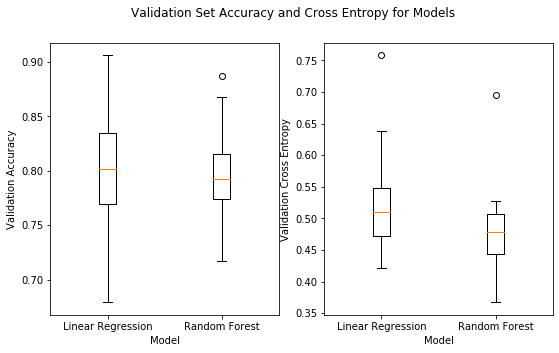

In [59]:
fig, axes = plt.subplots(1,2, figsize=(9,5))
ax = axes[0]
ax.boxplot([metrics['lr']['acc'], metrics['rf']['acc']])
ax.set_xticklabels(['Linear Regression', 'Random Forest'])
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel('Model')

ax = axes[1]
ax.boxplot([metrics['lr']['entropy'], metrics['rf']['entropy']])
ax.set_xticklabels(['Linear Regression', 'Random Forest'])
ax.set_ylabel('Validation Cross Entropy')
ax.set_xlabel('Model')

plt.suptitle('Validation Set Accuracy and Cross Entropy for Models')
None

In [60]:
rf_avg_importances = np.array([0.]*27)
for arr in rf_importances:
    rf_avg_importances += arr
rf_avg_importances /= len(rf_avg_importances)
rf_avg_importances

array([0.25072391, 0.29693085, 0.00669216, 0.01479976, 0.01890549,
       0.005338  , 0.003338  , 0.01501749, 0.00473868, 0.00418095,
       0.00696217, 0.00603194, 0.00505371, 0.00871599, 0.00469846,
       0.01566695, 0.0069421 , 0.00394341, 0.00716182, 0.00258456,
       0.00468309, 0.00278156, 0.01720452, 0.00513728, 0.00640668,
       0.01113407, 0.00496715])

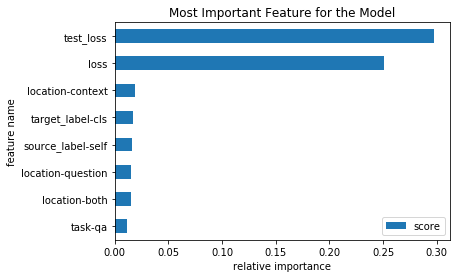

In [71]:
order = rf_avg_importances.argsort()[::-1]  ## descending
rf_avg_importances_sort = rf_avg_importances[order]
col_name_sort = (data_all.columns)[order]
df = pd.DataFrame({'col': col_name_sort[:8], 'score': rf_avg_importances_sort[:8]})
df.sort_values('score', inplace=True)
df.plot(kind='barh', x='col', y='score')
plt.title('Most Important Feature for the Model')
plt.xlabel('relative importance')
plt.ylabel('feature name')
None